In [2]:
import sys
sys.path.insert(1, './src')

from tagger import CrfModel
from data_loader import BuildDataLoader
from environment import LabelEnv
from agent import ParamRNN, AgentParamRNN

from gensim.models import KeyedVectors
import numpy as np
import random
import argparse
import matplotlib
import matplotlib.pyplot as plt
import pickle

import warnings; warnings.simplefilter('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable  

# if gpu is to be used
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print ("== Cuda: {} ===".format(torch.cuda.is_available()))


== Cuda: True ===


In [2]:
SOURCE = 'sod'
DATA_PATH = "./datasets/" + SOURCE
NUM_FLAG = True
EMBED_FLAG = False
FEAT = 'all'

dataloader = BuildDataLoader(SOURCE, DATA_PATH, NUM_FLAG, EMBED_FLAG)
crf = CrfModel(dataloader, FEAT)

=== data loading ===
word dict size: 25
label dict size: 126
Replace digit with NUM: True
use embedding: False
embedding size: 25
number of instances: 1335
=== Tagger initialized ===
-- label dict size: 126
-- word dict size: 25


In [8]:
samples = [4]
VALID_N = 200
TEST_N = 200
TRAIN_N = 600
REWEIGHT = 'valid2Tx'
GEEDY = 'te'
BUDGET = 2
max_len = dataloader.get_max_len()
embedding_size = dataloader.get_embed_size()
parameter_shape = crf.get_para_shape()
print ("max_len is: {}".format(max_len))
print ("crf para size: {}".format(parameter_shape))

qvalue_list = []
action_mark_list = []
prob_list = []
for seed in samples:
    env = LabelEnv(dataloader, crf, seed, VALID_N, TEST_N, TRAIN_N, REWEIGHT, BUDGET)
    agent = AgentParamRNN(GEEDY, max_len, embedding_size, parameter_shape)
    
    print (">>>> Start play")
    step = 0
    while env.cost < BUDGET:
        env.resume()
        observation = env.get_state()
        observ = [observation[0], observation[1], observation[3], observation[4], observation[5]] 
        greedy_flg, action, q_value = agent.get_action(observ)
        reward, observation2, terminal = env.feedback(action)
        (acc_test, acc_valid) = env.eval_tagger()
        print ("cost {}: queried {} with greedy {}:{}, acc=({}, {})".format(env.cost, action, greedy_flg, 
                                                                            q_value.item(), acc_test, acc_valid))
        
        qvalue_list.append(q_value.item())
        action_mark_list.append(greedy_flg)
        prob_list.append(observation[1][action])
        
        if env.cost % 10 == 0:
            step += 10
        
        if env.cost < 3:
            continue
            
        for n in range(20 + step):
            env.reboot()
            while env.terminal == False:
                observation = env.get_state()
                observ = [observation[0], observation[1], observation[3], observation[4], observation[5]] 
                greedy_flg, action, q_value = agent.get_action(observ)
                reward, observation2, terminal = env.feedback(action)
                observ2 = [observation2[0], observation2[1], observation2[3], observation2[4], observation2[5]]
                agent.update(observ, action, reward, observ2, terminal)
            

max_len is: 14
crf para size: (201, 126)
=== Env: data ===
train     : 600
validation: 200
test      : 200
=== Env: setup ===
reward reweight: valid2Tx
similarity for valid to test done -- size=(200,)
budget: 2
=== Agent: created
Q-net parameter size: 46769
>>>> Start play
cost 2: queried 382 with greedy 0:-0.3412691354751587, acc=(0.6507142857142857, 0.6660714285714284)


In [14]:
cost_list = sorted(env.acc_trace.keys())
acc_list = [env.acc_trace[i][0] for i in cost_list]
acc_valid_list = [env.acc_trace[i][1] for i in cost_list]

num = "num" if NUM_FLAG else ""
emb = "embed" if EMBED_FLAG else ""
filename = "./results_run/" + SOURCE + num + emb + "_" + str(BUDGET) + "bgt_" + GEEDY + "_" + REWEIGHT + "_" + FEAT

with open(filename + ".bin", "wb") as result:
    pickle.dump((cost_list, acc_list, acc_valid_list), result)

[-0.3412691354751587] [0] [0.8046558188143749]


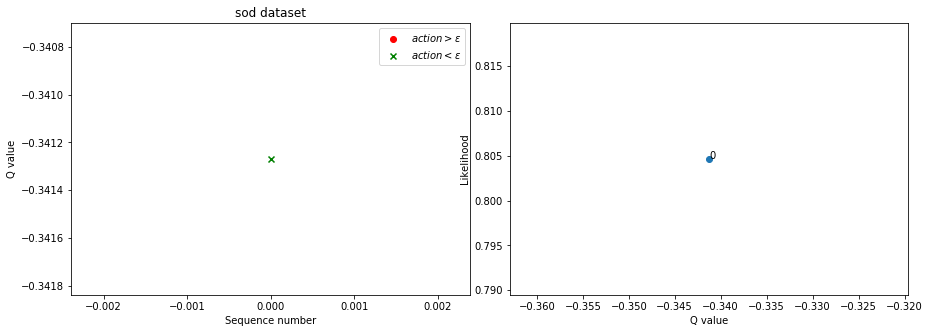

In [15]:
print (qvalue_list, action_mark_list, prob_list)
# ======================================== sanity check =====================================================
x = range(len(qvalue_list))

fig, axes = plt.subplots(ncols=2, nrows=1)
ax = axes.flatten()

ax[0].plot(x, qvalue_list, color='0.5')
x2 = []
y2 = []
for i in x:
    if action_mark_list[i] == 1:
        x2.append(i)
        y2.append(qvalue_list[i])
l1 = ax[0].scatter(x2, y2, color='r', marker='o')
x2 = []
y2 = []
for i in x:
    if action_mark_list[i] == 0:
        x2.append(i)
        y2.append(qvalue_list[i])
l2 = ax[0].scatter(x2, y2, color='g', marker='x')
ax[0].legend((l1,l2),
           ('$action > \\epsilon$', '$action < \\epsilon$'))

ax[0].set_title('{} dataset'.format(SOURCE))
# plt.xlim(0, 20)
ax[0].set_ylabel('Q value')
ax[0].set_xlabel('Sequence number')

# print (qvalue_list)
ax[1].scatter(qvalue_list, prob_list)
for i in range(len(qvalue_list)):
    ax[1].annotate(i, (qvalue_list[i], prob_list[i]))
ax[1].set_xlabel('Q value')
ax[1].set_ylabel('Likelihood')
plt.subplots_adjust(wspace=0.1)
fig.set_size_inches(15,5)
# plt.show()
plt.savefig(filename + '_check.png')

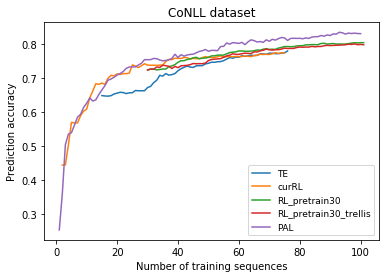

In [25]:
# sim beta
with open("./results/conll15_200_75budget_fully_none.bin", "rb") as in_file:
    (cost_1, _, _, all_acc_1, acc_valid_1) = pickle.load(in_file)
#     (cost_1, all_acc_1, acc_valid_1) = pickle.load(in_file)
       
with open("./results/conllnumembed_75bgt_te_valid2V_all.bin", "rb") as in_file:
    (cost_2, all_acc_2, acc_valid_2) = pickle.load(in_file)

with open("./results/conll30numembed_200_100budget_valid2VRL_all_te_acc_20step_5batch20decay_100loop-add10each10step-3_64rnn_16filter_4size_2stride.bin", "rb") as in_file:
    (cost_3, all_acc_3, acc_valid_3) = pickle.load(in_file)

with open("./results/conll30numembed_200_100budget_valid2VRLtrellis_all_te_acc_20step_5batch20decay_100loop-add10each10step-3_64rnn_16filter_4size_2stride.bin", "rb") as in_file:
    (cost_4, all_acc_4, acc_valid_4) = pickle.load(in_file)
    
with open("./results/CNNDQN-conll-20.bin", "rb") as in_file:
    (cost_5, all_acc_5, acc_valid_5) = pickle.load(in_file)

# with open("./results/sod15num_200_testVRL_acc2_all_rand_20step_5batch20decay_90loopdecay_64rnn_16filter_4size_2stride.bin", "rb") as in_file:
#     (cost_6, in_acc_6, out_acc_6, all_acc_6, acc_valid_6) = pickle.load(in_file)

# with open("./results/sod15num_200_testVRL_acc2_all_te_20step_5batch20decay_90loopdecay_64rnn_16filter_4size_2stride.bin", "rb") as in_file:
#     (cost_7, in_acc_7, out_acc_7, all_acc_7, acc_valid_7) = pickle.load(in_file)

plt.plot(cost_1, all_acc_1,
         cost_2, all_acc_2,
         cost_3, all_acc_3,
         cost_4, all_acc_4,
         cost_5, all_acc_5,)
#          cost_6, all_acc_6,)
#          cost_7, acc_valid_7)
plt.legend(['TE', 'curRL', 'RL_pretrain30', 'RL_pretrain30_trellis', 'PAL' ,'RL-test', 'RL-valid'], loc='lower right', fancybox=True, fontsize = 9)
# plt.xlim(200, 600)

plt.title('CoNLL dataset')
plt.xlabel('Number of training sequences')
plt.ylabel('Prediction accuracy')
plt.savefig('./results/sod.png', bbox_inches='tight')

